In [96]:
import torch
from torch import nn

batch_size = 256

导出训练集和测试集的加载器

In [97]:
from matplotlib import pyplot as plt
import torchvision
from torch.utils import data
from torchvision import transforms

def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集,然后将其加载到内存中。"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)

    mnist_train = torchvision.datasets.FashionMNIST(root=r'..\data\F_MNIST_data_train', train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root=r'..\data\F_MNIST_data_test', train=False, transform=trans, download=True)

    return (
        data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4),
        data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=4)
    )

train_iter, test_iter = load_data_fashion_mnist(batch_size)

定义线性神经网络，还没有softmax版本，作用是：将图片的数据展平，并线性回归输出十个分类的未归一化权重作为分量的一维张量

In [98]:
# 对Sequential的说明
# 这是 PyTorch 中的一个容器类，用于按顺序组合多个神经网络层。
# 它可以将一系列的层包装成一个整体，形成一个完整的神经网络模型，
# 方便进行前向传播计算，只需将输入数据传入nn.Sequential实例，
# 它就会按照层的顺序依次对数据进行处理。
net = nn.Sequential(nn.Flatten(), nn.Linear(784,10))

# 如果是线性层，用正态分布来初始化权重，
# 标准差std设置为0.01
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std=0.01)

# 对net中的层作用一下init_weights函数
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

设置损失函数，以交叉熵函数设置，但是同时里面有将为归一化的预测softmax归一化的过程，然后才输入到交叉熵函数里面去，返回的是批量数个对数

In [99]:
loss = nn.CrossEntropyLoss()

用sgd随机梯度下降作为优化算法

In [100]:
trainer = torch.optim.SGD(net.parameters(), lr = 0.1)

导入之前写的训练函数及其前置函数

In [101]:
def accuracy(y_hat,y):
    '''计算正确预测的数量'''
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [102]:
class Accumulator(object):
    def __init__(self, n):
        """
        初始化累加器。
        :param n: 要累加的统计量的数量
        """
        self.data = [0.0] * n

    def add(self, *args):
        """
        累加输入的值。
        :param args: 要累加的值，数量应与初始化时的统计量数量一致
        """
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        """
        获取指定索引位置的累加值。
        :param idx: 索引
        :return: 对应索引位置的累加值
        """
        return self.data[idx]  

In [103]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X,y in train_iter:
        y_hat = net(X)
        l = loss(y_hat,y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l) * len(y), accuracy(y_hat,y), 
                y.size().numel()
            )
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(
                float(l.sum()), accuracy(y_hat,y), y.numel()
            )
    return metric[0]/metric[2], metric[1]/metric[2]

In [104]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), figsize=(10, 4)):
        
        self.X = self.Y = None
        self.fmts = fmts
        if legend is None:
            legend = []
        
        # 创建两个子图，第一个用于 loss，第二个用于其他数据
        self.fig, self.axes = plt.subplots(1, 2, figsize=figsize, sharex=True)
        
        self.config_axes_loss = lambda: self.set_axes(self.axes[0], xlabel, "Loss", xlim, None, xscale, yscale, [legend[0]])
        self.config_axes_main = lambda: self.set_axes(self.axes[1], xlabel, ylabel, xlim, ylim, xscale, yscale, legend[1:])
    
    def set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """手动设置坐标轴"""
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        if xlim: ax.set_xlim(xlim)
        if ylim: ax.set_ylim(ylim)
        if legend: ax.legend(legend)

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if self.X is None:
            self.X = [[] for _ in range(n)]
        if self.Y is None:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        
        self.axes[0].cla()  
        self.axes[1].cla()  
        
        # 绘制 loss (单独的曲线)
        self.axes[0].plot(self.X[0], self.Y[0], self.fmts[0], label="Loss")
        self.config_axes_loss()
        
        # 绘制其余数据
        for x, y, fmt in zip(self.X[1:], self.Y[1:], self.fmts[1:]):
            self.axes[1].plot(x, y, fmt)
        self.config_axes_main()
        
        display(self.fig)

In [105]:
def evaluate_accuracy(net,data_iter):
    '''计算指定数据集上模型的精度'''
    if isinstance(net, torch.nn.Module):
        net.eval()#设置模型为评估模式
    metric = Accumulator(2)
    for X,y in data_iter:
        metric.add(accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

evaluate_accuracy(net,test_iter)

0.106

In [106]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs,updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1.0],legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter,loss,updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1,train_metrics + (test_acc,))
    train_loss,train_acc = train_metrics

调用之前写的训练函数来训练模型

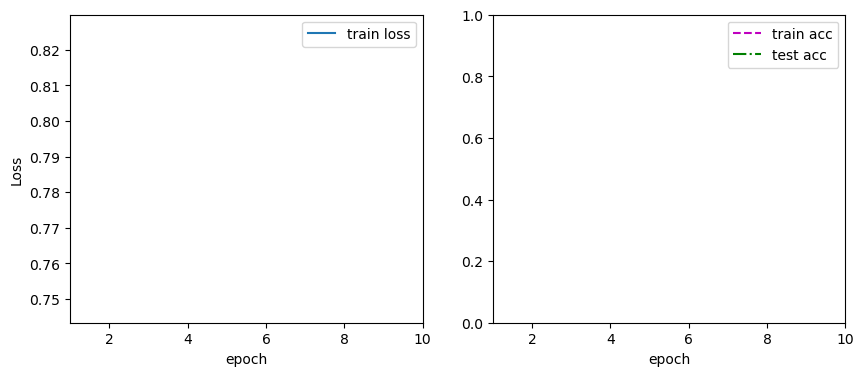

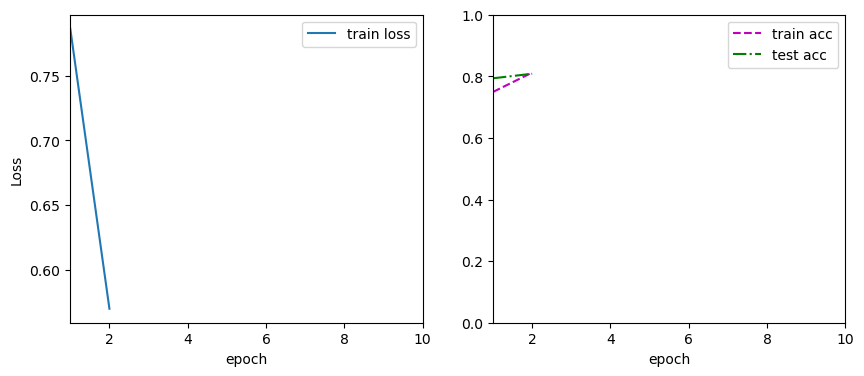

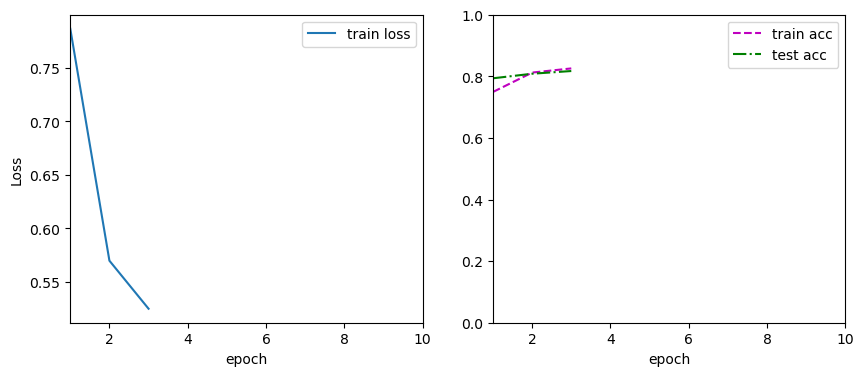

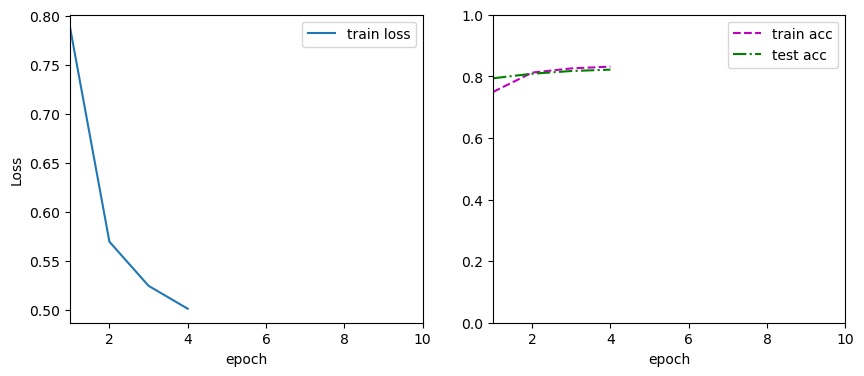

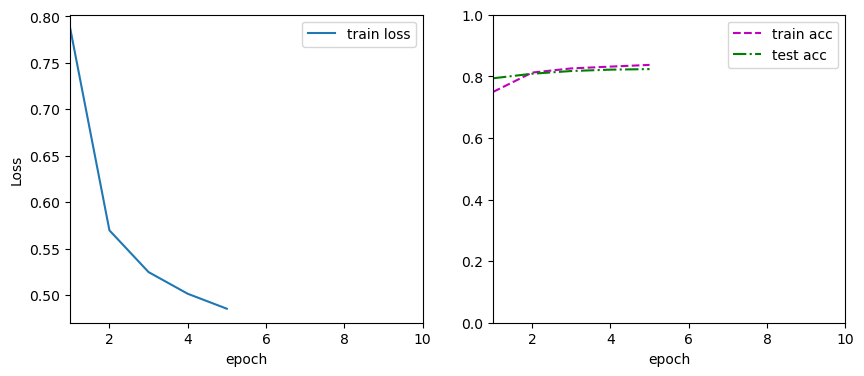

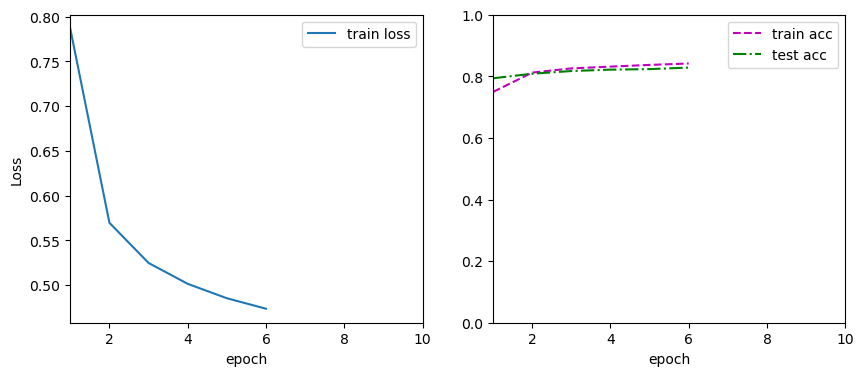

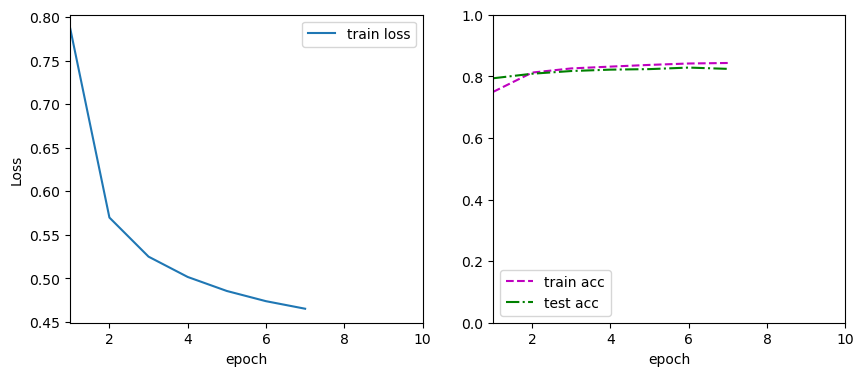

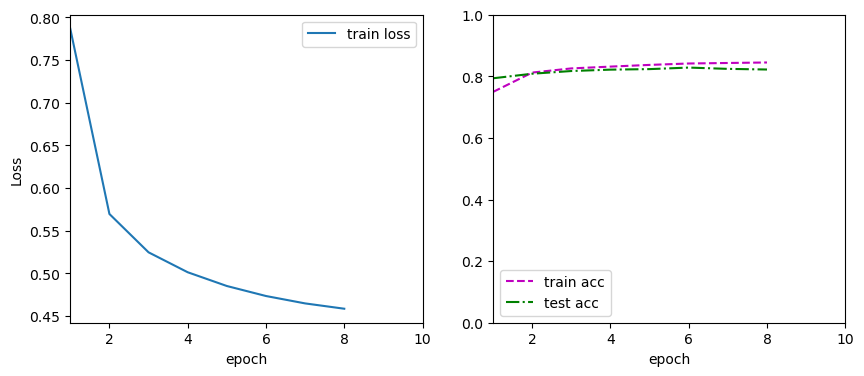

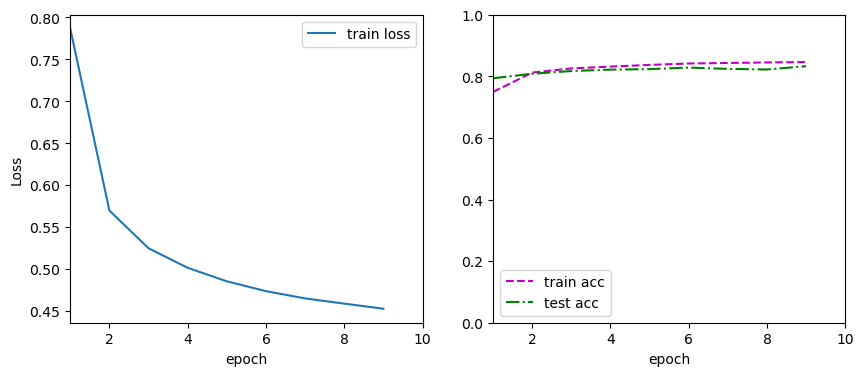

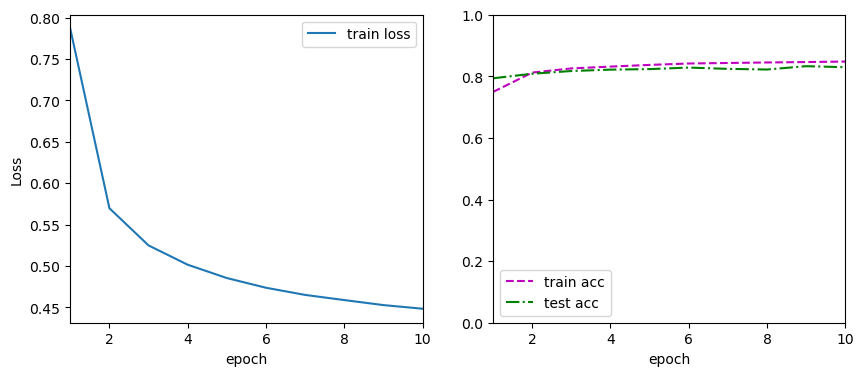

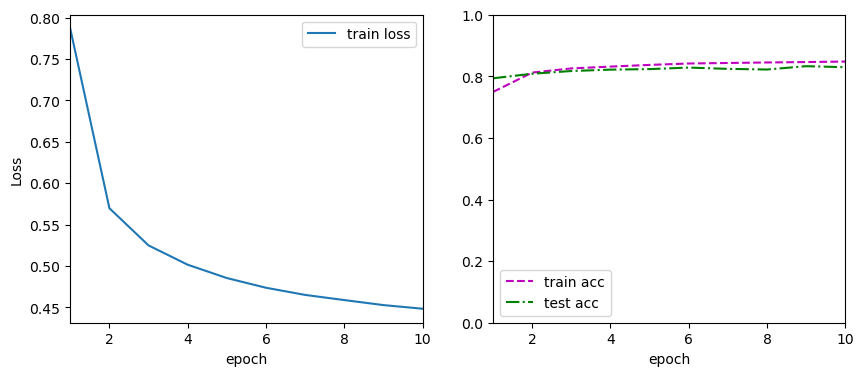

In [107]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)